In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut

In [2]:
bench_std = pd.read_csv('./results/sim/joint_benchmarks.csv', index_col=0)
bench_10k = pd.read_csv('./results/sim/10k/joint_benchmarks.csv', index_col=0)
bench_all = pd.concat([bench_std, bench_10k], axis=0, join='inner')
bench_all = bench_all.reset_index()

algs = ['CAM', 'FCI', 'FGES', 'PC', 'LINGAM', 'NOTEARS']
algs.sort()

/home/damian/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (24,26,27,28,29,33,34,39,41,42,43,44,45,47,48,57,58,59,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Oracle

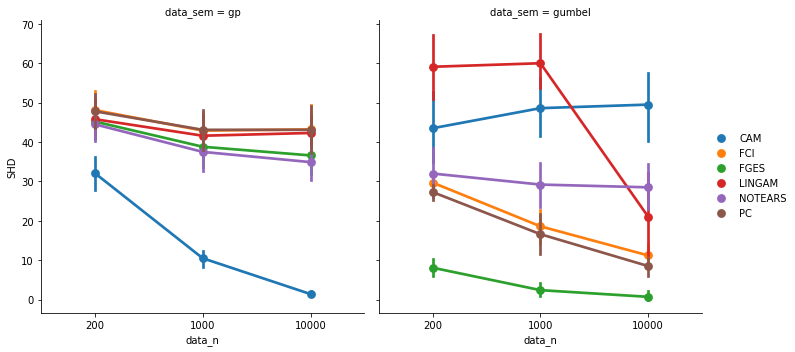

In [9]:
df = ut.best_h(bench_all)

df['graph_type_d'] = df.apply(lambda x: f"{x['graph_type'].upper()}{x['graph_d']}", axis=1)
df['id'] = df.apply(lambda x: x['id'].upper(), axis=1)

#df_selected = df.loc[(df['graph_d'] == 1) & (df['graph_p'] == 50) & (df['graph_type'] == 'er')]
df_selected = df.loc[(df['graph_d'] == 1) & (df['graph_p'] == 50) & (df['graph_type'] == 'er') & (df['id'].isin(algs))]

g = sns.catplot(data=df_selected, x='data_n', y='SHD_pattern', hue='id', col='data_sem', errorbar='se', kind='point', sharey=True)
g.set(ylabel='SHD')
g._legend.set_title('')
plt.savefig('./plots/10k/10k_oracle.pdf', dpi=1000)

## Model selection

In [4]:
df = ut.extract_cols(bench_all)
df['id'] = df.apply(lambda x: x['id'].upper(), axis=1)

df_selected = df.loc[(df['graph_d'] == 1) & (df['graph_p'] == 50) & (df['graph_type'] == 'er') & (df['id'].isin(algs))]

df_win = df_selected.groupby(['data_sem', 'data_n', 'replicate'], as_index=False).apply(lambda x: x.loc[x['SHD_pattern'].idxmin()])

In [5]:
df_win['id'].value_counts(normalize=True).reset_index()

,index,id
0,CAM,0.500000
1,FGES,0.483333
2,FCI,0.016667


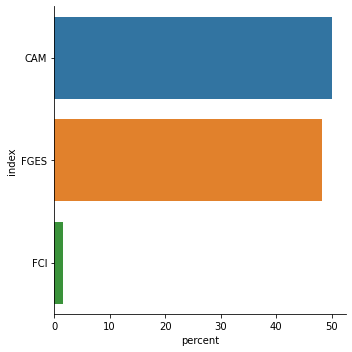

In [6]:
(df_win['id']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='percent', y='index', kind='bar', orient='h'))
#plt.savefig('./plots/model_selection/all.pdf', dpi=1000)

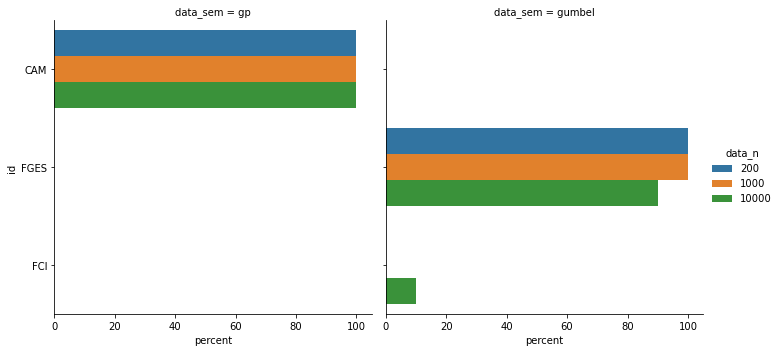

In [7]:
gr='data_n'
for col in ['data_sem']:
    (df_win
    .groupby([gr, col])['id']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.catplot, 'data'), x='percent', y='id', hue=gr, col=col, kind='bar', orient='h'))
    #plt.show()
    #plt.savefig(f'./plots/model_selection/h_{col}.pdf', dpi=1000)

## H dist

In [10]:
df = ut.extract_cols(bench_all)
df['id'] = df.apply(lambda x: x['id'].upper(), axis=1)

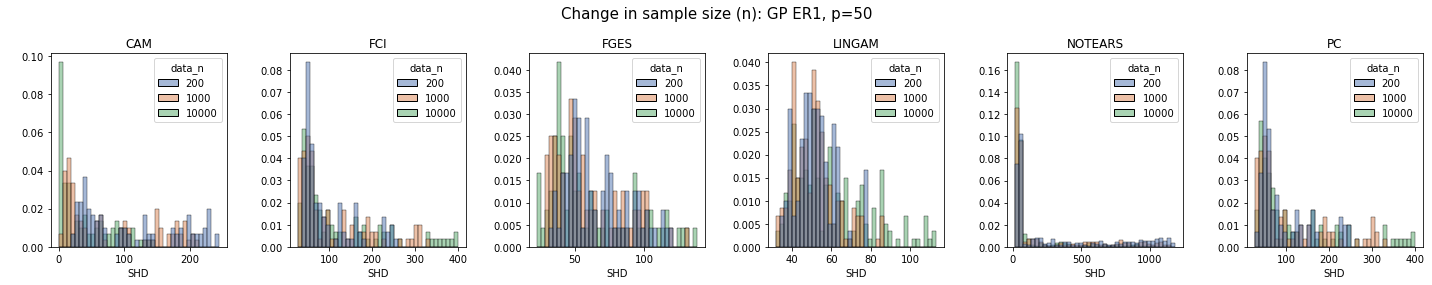

In [11]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))
axes = axes.flatten()

gt = 'er'
p = 50
d = 1
sem = 'gp'
df_case = df.loc[(df['graph_type'] == gt) & (df['graph_p'] == p) & (df['graph_d'] == d) & (df['data_sem'] == sem) & (df['id'].isin(algs))]
fig.suptitle(f'Change in sample size (n): {sem.upper()} {gt.upper()}{d}, p={p}', fontsize=15)

for ax, alg in zip(axes, algs):
    ax.set_title(alg.upper())
    ax.set_xlabel('SHD')
    ax.set_ylabel(' ')
    sns.histplot(df_case.loc[df_case['id'] == alg], x='SHD_pattern', hue='data_n', ax=ax, stat='probability', palette='deep', bins=40)

plt.tight_layout()

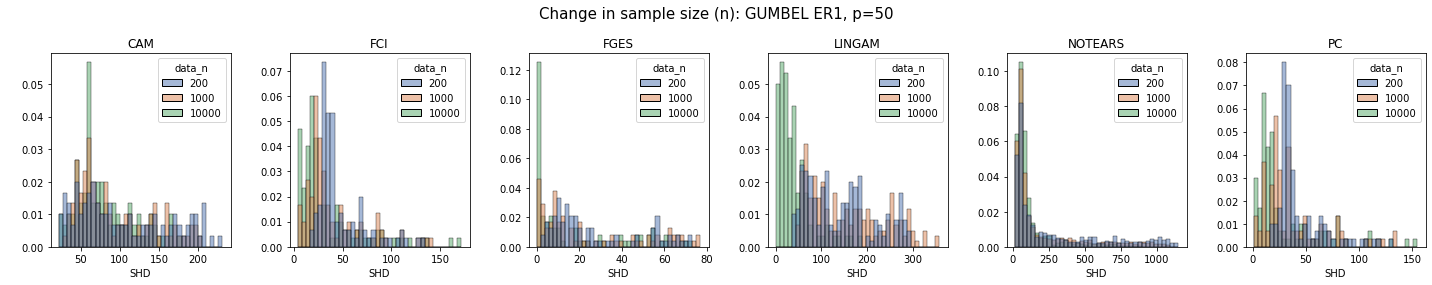

In [13]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))
axes = axes.flatten()

gt = 'er'
p = 50
d = 1
sem = 'gumbel'
df_case = df.loc[(df['graph_type'] == gt) & (df['graph_p'] == p) & (df['graph_d'] == d) & (df['data_sem'] == sem) & (df['id'].isin(algs))]
fig.suptitle(f'Change in sample size (n): {sem.upper()} {gt.upper()}{d}, p={p}', fontsize=15)

for ax, alg in zip(axes, algs):
    ax.set_title(alg.upper())
    ax.set_xlabel('SHD')
    ax.set_ylabel(' ')
    sns.histplot(df_case.loc[df_case['id'] == alg], x='SHD_pattern', hue='data_n', ax=ax, stat='probability', palette='deep', bins=40)

plt.tight_layout()

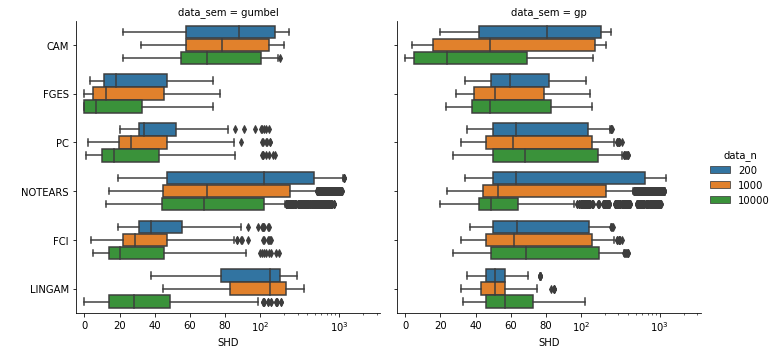

In [8]:
gt = 'er'
p = 50
d = 1
df_case = df.loc[(df['graph_type'] == gt) & (df['graph_p'] == p) & (df['graph_d'] == d) & (df['id'].isin(algs))]

sns.catplot(data=df_case, x='SHD_pattern', y='id', col='data_sem', hue='data_n', kind='box', orient='h').set(xlabel='SHD', ylabel=' ')

plt.xscale('symlog', linthresh=1e2, linscale=2.0, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlim(-5, 1e4/3)
plt.xticks([0, 20, 40, 60, 80, 1e2, 1e3], labels=[0, 20, 40, 60, 80, '$10^2$', '$10^3$'])

plt.savefig('./plots/10k/10k_h_box.pdf', dpi=1000)

## Cumulative

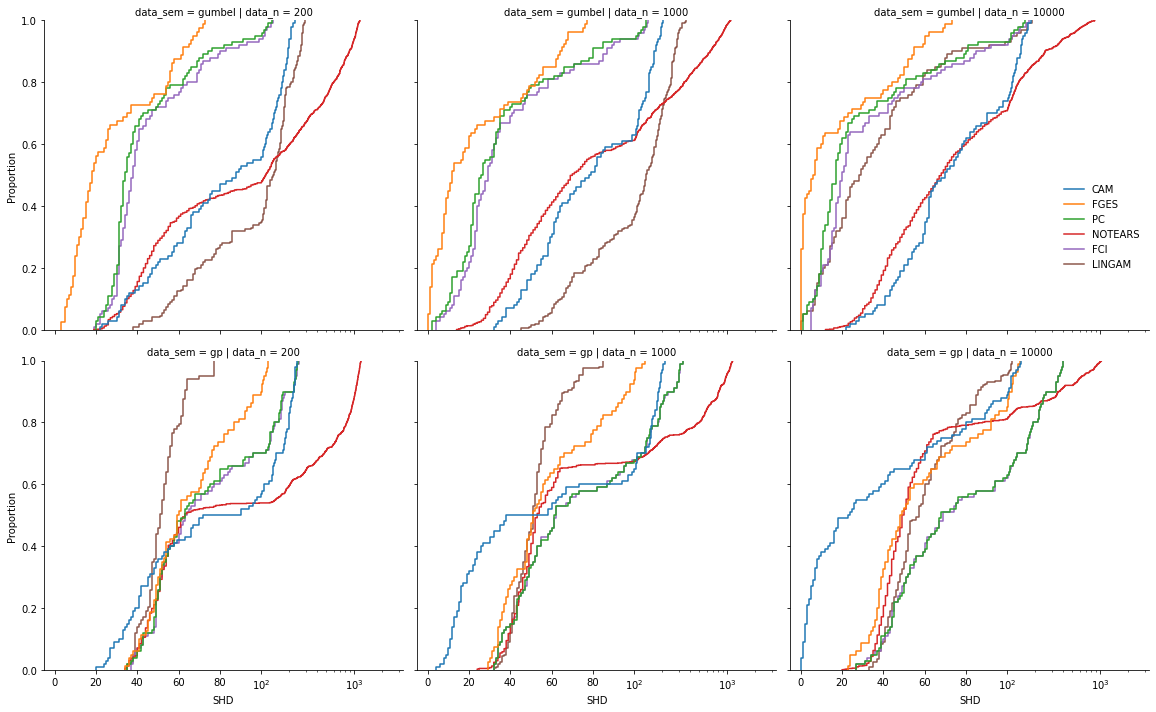

In [25]:
gt = 'er'
p = 50
d = 1
df_case = df.loc[(df['graph_type'] == gt) & (df['graph_p'] == p) & (df['graph_d'] == d) & (df['id'].isin(algs))]

g = sns.displot(data=df_case, x='SHD_pattern', hue='id', row='data_sem', col='data_n', kind='ecdf')
g.set(xlabel='SHD')
sns.move_legend(g, 'upper right', bbox_to_anchor=(.99, .75), title='')

plt.xscale('symlog', linthresh=1e2, linscale=2.0, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlim(-5, 1e4/3)
plt.xticks([0, 20, 40, 60, 80, 1e2, 1e3], labels=[0, 20, 40, 60, 80, '$10^2$', '$10^3$'])

plt.tight_layout()
plt.savefig('./plots/10k/10k_h_ecdf.pdf', dpi=1000)